# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Выбросы" data-toc-modified-id="Выбросы-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Выбросы</a></span><ul class="toc-item"><li><span><a href="#Год-регистрации-RegistrationYear" data-toc-modified-id="Год-регистрации-RegistrationYear-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Год регистрации <code>RegistrationYear</code></a></span></li><li><span><a href="#Мощность-Power" data-toc-modified-id="Мощность-Power-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Мощность <code>Power</code></a></span></li><li><span><a href="#Цена-Price" data-toc-modified-id="Цена-Price-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Цена <code>Price</code></a></span></li><li><span><a href="#Месяц-регистрации-RegistrationMonth" data-toc-modified-id="Месяц-регистрации-RegistrationMonth-2.1.4"><span class="toc-item-num">2.1.4&nbsp;&nbsp;</span>Месяц регистрации <code>RegistrationMonth</code></a></span></li></ul></li><li><span><a href="#Пропуски" data-toc-modified-id="Пропуски-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Пропуски</a></span></li><li><span><a href="#Приведение-типов-данных" data-toc-modified-id="Приведение-типов-данных-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Приведение типов данных</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ моделей</a></span></li></ul></div>

## Описание данных

**Признаки**
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**
- `Price` — цена (евро)

In [1]:
# Библиотеки
# для вывода
from IPython.display import Markdown, display
from tqdm.notebook import tqdm_notebook as tqdm
import warnings
import time
# для работы с данными
import pandas as pd
from pandas_profiling import ProfileReport
from matplotlib import pyplot as plt
import seaborn as sns
# для обучения
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor 
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
# константы
RANDOM_STATE = 123

In [2]:
def dataframe_info(df):
    ''' Вывод информации о датафрейме `df`. Функционал схож с методом `pd.DataFrame.info()`

    Дополнительно: вывод процента заполненных (non-null) значений, количестве дублей
    '''
    info = (pd.DataFrame({
                'notNA': df.count(), 'notNA, %': df.count()/df.shape[0]*100,
                'dtype': df.dtypes})
            .style.bar(subset='notNA, %', vmin=0, color='lightblue')
            .format("{:.2f}", subset=['notNA, %'])
    )
    print('DataFrame shape  : {} rows, {} columns'.format(df.shape[0], df.shape[1]))
    print('Memory usage     : {:.2f} MB'.format(df.memory_usage().sum()/1024/1024))
    print('Duplicates count :', df.duplicated().sum())
    return info

def show_hist(df, col, bins=100, xlim=None, ylim=None, figsize=None,
              title='Распределение значений',
              xlabel=None, ylabel='Количество значений'):
    '''
    Функция построения гистограмм и диаграмм размаха для столбца col датафрейма df
    
    Параметры 
    ---
    `bins` : int - задаёт число корзин для гистограммы, по умолчанию 100
    `title` : string - задаёт название графика
    `xlabel, ylabel` : string - подписи к осям
    `xlim, ylim, figsize` : параметры matplotlib 
    '''
    # создаём 3 сабплота, указываем для них соотношение занимаемой высоты
    _, (ax_box, ax_hist) = plt.subplots(2, sharex=True,
        gridspec_kw={"height_ratios": (.15, .85)}, figsize=figsize)

    if col in df.columns:
        # диаграмма размаха, гистограмма с функцией распределения
        sns.boxplot(x=df[col], ax=ax_box)
        sns.histplot(df[col], ax=ax_hist, bins=bins, kde=True)
        if xlabel is None: 
            xlabel = col
        ax_box.set(xlabel='')  # чтобы не дублировалась
        ax_hist.set(xlabel=xlabel, ylabel=ylabel, xlim=xlim, ylim=ylim)
        ax_hist.grid(visible=True)
        plt.suptitle(title, y=0.92, fontsize=14)
    else:
        print('Столбец', col, 'отсутсвует в датафрейме')

def visualize_value_counts(df, column, n_values=25, fillna='NONE'):
    ''' Визуализация количества встречающихся значений столбца датафрейма

    `df` : pd.DataFrame - датафрейм
    `column` : string - название столбца
    `n_values` : int - максимальное количество значений для отображения на диаграмме
    `fillna` : any - значение, которым необходимо заполнить пропуски
    '''
    val_counts = df[column].fillna(fillna).value_counts()
    bar_values = val_counts.values[:n_values]
    bar_labels = val_counts.index[:n_values]
    plt.figure(figsize=(8, 0.35*min(len(val_counts), n_values)))
    ax = sns.barplot(x=bar_values, y=bar_labels)
    ax.set(title='"{}" value counts ({} / {})'
           .format(column, len(bar_labels), val_counts.shape[0]),
           xlim=[0, 1.1*bar_values.max()])
    plt.bar_label(ax.containers[0])
    for i in range(len(bar_labels)):
        if bar_labels[i] == fillna:
            ax.patches[i].set_color('black')
    plt.show()

## Подготовка данных

Загрузим данные, изучим их

In [3]:
df = pd.read_csv('../datasets/autos.csv')

display(df.sample(5))
display(dataframe_info(df))
display(df.describe())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
317567,2016-03-12 09:52:55,3590,sedan,1989,manual,26,601,30000,4,petrol,trabant,no,2016-03-12 00:00:00,0,14822,2016-03-20 06:47:18
73701,2016-03-05 14:55:09,1350,bus,1994,manual,70,ducato,150000,10,gasoline,fiat,no,2016-03-05 00:00:00,0,26723,2016-04-07 10:45:52
90738,2016-03-17 17:42:14,9850,sedan,2009,manual,122,1er,60000,11,petrol,bmw,no,2016-03-17 00:00:00,0,69226,2016-03-23 05:46:56
281930,2016-03-06 21:40:25,11700,sedan,2004,auto,231,5er,150000,6,petrol,bmw,no,2016-03-06 00:00:00,0,55129,2016-04-07 06:16:02
99011,2016-04-03 15:55:19,1600,NaN,2017,manual,111,almera,150000,8,NaN,nissan,no,2016-04-03 00:00:00,0,52222,2016-04-05 15:16:37


DataFrame shape  : 354369 rows, 16 columns
Memory usage     : 43.26 MB
Duplicates count : 4


,notNA,"notNA, %",dtype
DateCrawled,354369,100.00,object
Price,354369,100.00,int64
VehicleType,316879,89.42,object
RegistrationYear,354369,100.00,int64
Gearbox,334536,94.40,object
Power,354369,100.00,int64
Model,334664,94.44,object
Kilometer,354369,100.00,int64
RegistrationMonth,354369,100.00,int64
FuelType,321474,90.72,object


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Есть 4 дубля. 

В строковых столбцах имеются пропуски. Это категориальные признаки. Особенно часто не заполняют информацию о том, ремонтировался ли автомобиль. 

В столбцах замечаем следующие проблемы:
- `RegistrationYear` - слишком маленькие и слишком большие значения
- `RegistrationMonth` - имеются значения от 0 до 12 включительно, вероятнее всего 0 быть не должно
- `Power` - есть нулевые значения и слишком большие (тысячи л.с.)
- `NumberOfPictures` - нет ничего, кроме нулей. Этот столбец можно удалить.
- `PostalCode` - числовой целочисленный, однако индекс некорректно считать числовым признаком, он характеризует географическое положение
- `Price` - нулевые значения

Столбцы `DateCrawled`, `DateCreated` и `LastSeen` - даты активности пользователя и выгрузки анкеты. Для предсказания строимости автомобиля они бесполезны, поскольку не влияют на неё.

Определим крайнюю дату выгрузки объявлений из системы: позднее неё автомобили не могли быть зарегистрированы.

In [4]:
print('Крайняя дата выгрузки:', df['DateCrawled'].max())

Крайняя дата выгрузки: 2016-04-07 14:36:58


- Удалим столбцы, значения в которых бесполезны для обучения моделей - столбцы с датами. 
- Также избавимся почтового индекса и количества картинок 

In [5]:
for f in ['NumberOfPictures', 'DateCrawled', 'DateCreated', 'LastSeen']:
    if f in df.columns:
        df.drop(f, axis=1, inplace=True)

print('Количество дублей', df.duplicated().sum())

Количество дублей 21333


Теперь количество дублей более 20000. Возможно это связано с тем, что некоторые объявления были выгружены из системы или опубликованы пользователями повторно. Вероятность совпадения сразу всех параметров мала - избавимся от них.

In [6]:
df = df.drop_duplicates(ignore_index=True)
df.shape

(333036, 12)

Изучим распределения величин

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    profile = ProfileReport(df)
    # profile.to_widgets()
    profile.to_file("autos_profiling.html")
    del profile

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 111.16it/s]


- Аномальные значения отсутсвуют только у пробега. Однако значения у него _дискретны_. 
- Очень большой разброс значений года регистрации
- Присутсвуют возможно слишком высокие и слишком низкие значения цены
- Очень часто встречается нулевое значение месяца регистрации - 10 % случаев.
- Много нулей в столбце мощности - 11 %. Большой разброс значений.

Можно избавиться от индексов, зависимость цены от него - очень слабая

In [8]:
if 'PostalCode' in df.columns:
    df.drop('PostalCode', axis=1, inplace=True)

### Выбросы

#### Год регистрации `RegistrationYear`

Выведем значения года < 1950 и > 2016

In [9]:
print('Аномальные значения :\n',
      df.query('RegistrationYear > 2016 or RegistrationYear < 1950')['RegistrationYear']
      .sort_values().unique())

Аномальные значения :
 [1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 2017 2018 2019 2066 2200 2222 2290 2500 2800 2900 3000 3200 3500
 3700 3800 4000 4100 4500 4800 5000 5300 5555 5600 5900 5911 6000 6500
 7000 7100 7500 7800 8000 8200 8455 8500 8888 9000 9229 9450 9996 9999]


Посмотрим, как много объявлений с годом < 1970 и > 2016. Вряд ли ещё есть автомобили на ходу ранее этого года. Даже если такие и продаются, то это скорее коллекционные экземляры, для обучения моделей их примеров будет слишком мало.

RegistrationYear < 1970 : 1309
RegistrationYear > 2016 : 13912


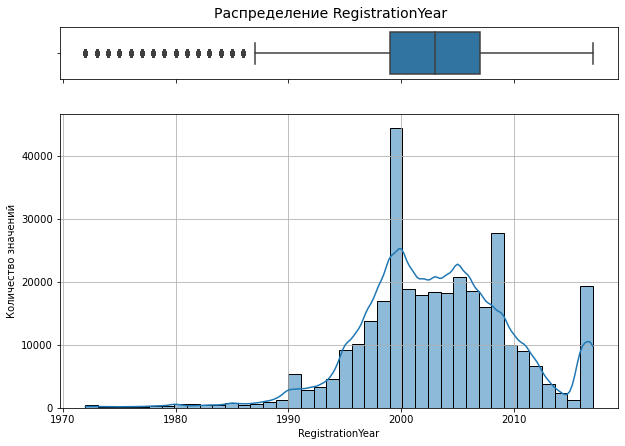

In [10]:
f = 'RegistrationYear'
print(f+' < 1970 :', (df[f] < 1970).sum())
print(f+' > 2016 :', (df[f] > 2016).sum())

show_hist(df[(df[f] > df[f].quantile(.005)) & (df[f] < df[f].quantile(.995))],
          f, bins=40,  figsize=(10, 7), title='Распределение '+f)

Объявления с указанным годом и месяцем регистрации автомобиля позднее апреля 2016 отфильтруем. После фильтрации потеряем около 5 процентов объектов. 

(313266, 11)

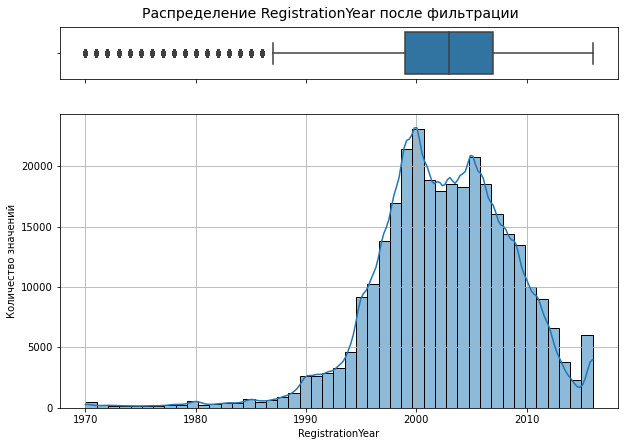

In [11]:
df = df.query('1970 <= RegistrationYear <= 2016')
df = df.query('not (RegistrationYear == 2016 and RegistrationMonth > 4)')
show_hist(df, f, bins=45,  figsize=(10, 7), 
          title='Распределение '+f+' после фильтрации')
df.shape 

#### Мощность `Power`

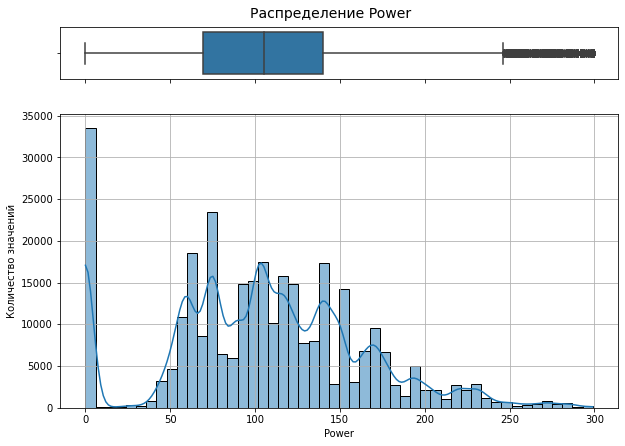

In [12]:
f = 'Power'
show_hist(df[df[f] < df[f].quantile(.99)],
          f, bins=50,  figsize=(10, 7), title='Распределение '+f)

In [13]:
print(f+' =   0 :', (df[f] == 0).sum())
print(f+' > 500 :', (df[f] > 500).sum())

Power =   0 : 33396
Power > 500 : 396


Слишком много нулевых значений мощности, однако их восстановить не получится, отфильтруем. Верхний предел установим равным 500, Автомобили с большей мощностью - редкость

count    279275.000000
mean        120.505058
std          53.355474
min          10.000000
25%          75.000000
50%         111.000000
75%         150.000000
max         500.000000
Name: Power, dtype: float64

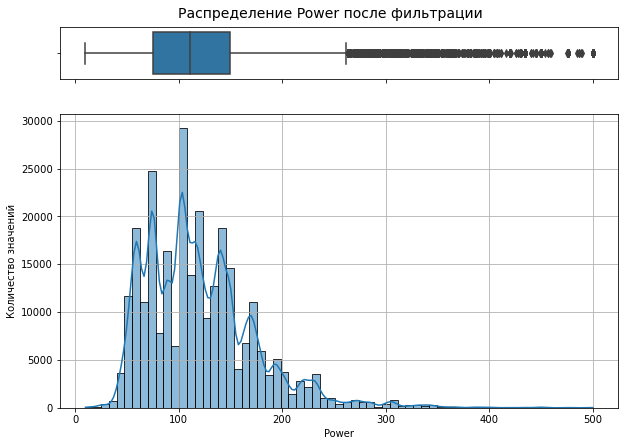

In [14]:
df = df.query('10 <= Power <= 500')
show_hist(df, f, bins=65,  figsize=(10, 7), title='Распределение '+f+' после фильтрации')
df[f].describe()

#### Цена `Price`

14999.0

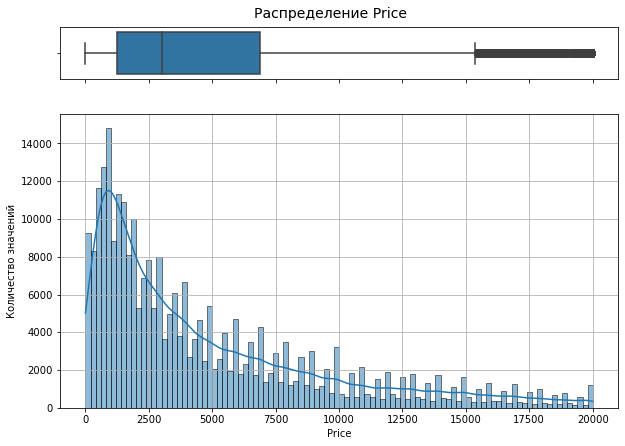

In [15]:
f = 'Price'
show_hist(df, f, bins=100,  figsize=(10, 7), title='Распределение '+f)
df[f].quantile(0.95)

In [16]:
print(f+' <    100 :', (df[f] < 100).sum())
print(f+' >= 15000 :', (df[f] >= 15000).sum())

Price <    100 : 6744
Price >= 15000 : 13619


Распределение похоже на реальное. Пики обусловлены округлением цен до 500 евро или до сотен евро. 20000 евро - вполне возможная цена, однако из-за слишком длинного хвоста в распределении мы имеем высокое стандартное отклонение, как следствие не сможем добиться хорошего качества предсказангия моделей. Цена ниже 100 евро подозрительна. Отбросим такие значения.

count    258912.000000
mean       4189.916771
std        3674.863273
min         100.000000
25%        1290.000000
50%        2950.000000
75%        6200.000000
max       14999.000000
Name: Price, dtype: float64

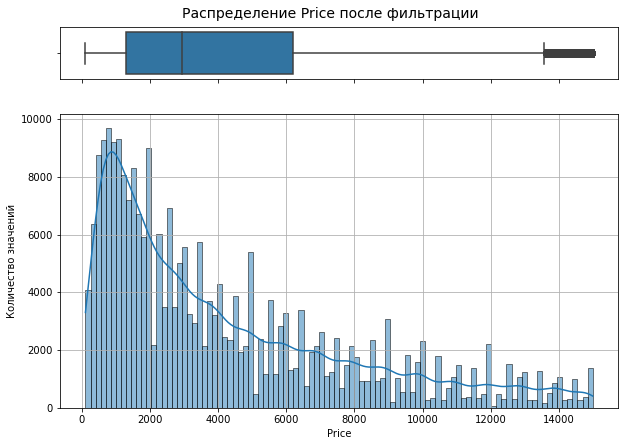

In [17]:
df = df.query('100 <= Price < 15000')
show_hist(df, f, bins=100, figsize=(10, 7), title='Распределение '+f+' после фильтрации')
df[f].describe()

Разброс значений всё ещё большой

#### Месяц регистрации `RegistrationMonth`

Как уже было замечено, встречается нулевое значение месяца. Вероятнее всего в таких объявлениях он не был указан. 

Встречаемость разных значений месяца

Коэффициент корелляции с целевым признаком: 0.0772851044560003


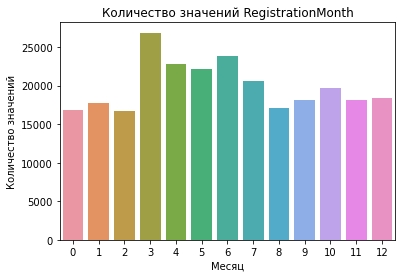

In [18]:
df_month_counts = df['RegistrationMonth'].value_counts().sort_index()
ax = sns.barplot(y=df_month_counts.values, x=df_month_counts.index)
ax.set(title='Количество значений RegistrationMonth',
       xlabel='Месяц', ylabel='Количество значений')

del df_month_counts
print('Коэффициент корелляции с целевым признаком:', 
      df['RegistrationMonth'].corr(df['Price']))

Заменим нули значениями, выбранными случайно из заполненных значений столбца.

In [19]:
df.loc[df['RegistrationMonth'] == 0, 'RegistrationMonth'] = pd.Series(
    index= df[df['RegistrationMonth']==0].index,
    data=df[df['RegistrationMonth'] != 0]['RegistrationMonth'].sample(
        (df['RegistrationMonth'] == 0).sum()).values
)

print('Коэффициент корелляции с целевым признаком:',
      df['RegistrationMonth'].corr(df['Price']))

Коэффициент корелляции с целевым признаком: 0.01747394009708719


Когда избавились от нулевых значений месяца, зависимость месяца регистрации от цены стала ещё слабже. По сравнению с остальными численными параметрами от месяца цена зависит значительно меньше.   
Обычно при покупке поддержанного авто решающим является только год, поэтому избавимся от него  

In [20]:
if 'RegistrationMonth' in df.columns:
    df.drop('RegistrationMonth', axis=1, inplace=True)

(258912, 10)

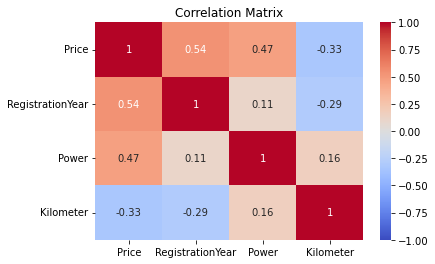

DataFrame shape  : 258912 rows, 10 columns
Memory usage     : 19.75 MB
Duplicates count : 19930


,notNA,"notNA, %",dtype
Price,258912,100.00,int64
VehicleType,251743,97.23,object
RegistrationYear,258912,100.00,int64
Gearbox,254047,98.12,object
Power,258912,100.00,int64
Model,249287,96.28,object
Kilometer,258912,100.00,int64
FuelType,245638,94.87,object
Brand,258912,100.00,object
NotRepaired,220312,85.09,object


In [21]:
df = df.reset_index(drop=True)
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()
dataframe_info(df)

Мультиколлинеарности численных признаков не наблюдаем

Вновь возникли дубли из-за совпадения значений месяца.

Потеряли около 28 % изначального объёма данных.

### Пропуски

Выделим категориальные признаки в список. Посмотрим распределения значений. Далее заполним пропуски в них

`VehicleType`, unique values: 8
['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon']



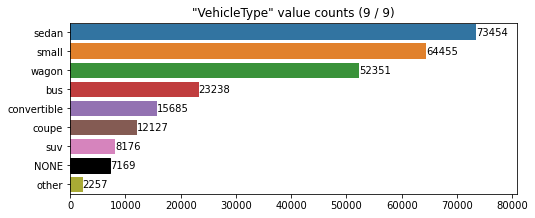

`Gearbox`, unique values: 2
['auto', 'manual']



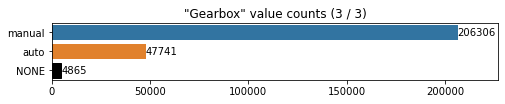

`Model`, unique values: 249
['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos', 'escort', 'espace', 'exeo', 'fabia', 'fiesta', 'focus', 'forester', 'forfour', 'fortwo', 'fo

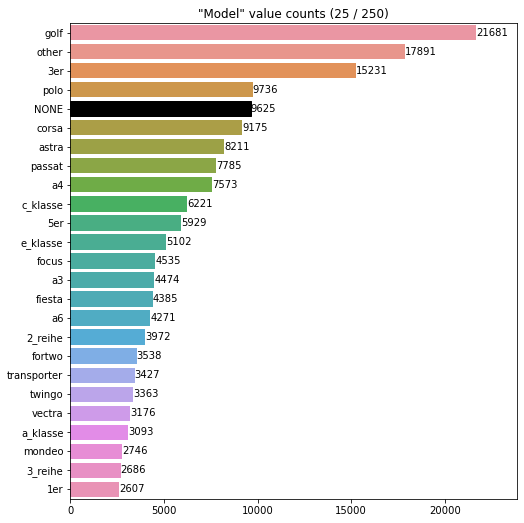

`FuelType`, unique values: 7
['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol']



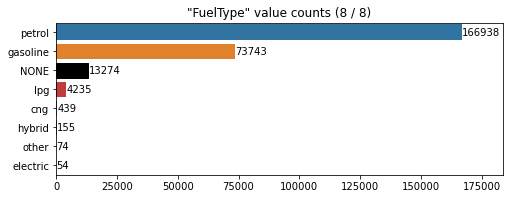

`Brand`, unique values: 40
['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen', 'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai', 'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda', 'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot', 'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart', 'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant', 'volkswagen', 'volvo']



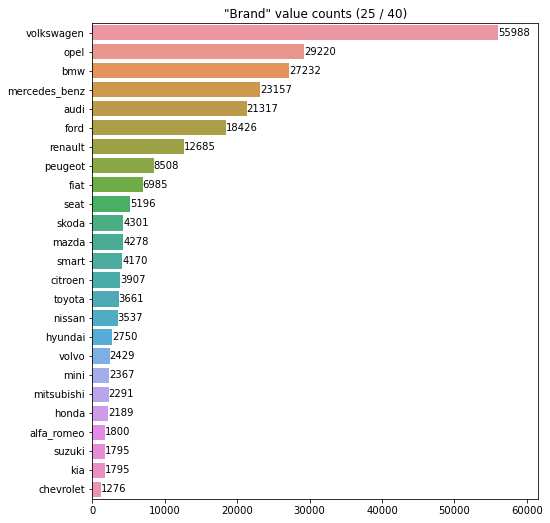

`NotRepaired`, unique values: 2
['no', 'yes']



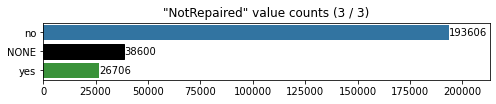

In [22]:
int_features = list(df.select_dtypes('integer').columns)
cat_features = list(df.select_dtypes('object').columns)
for f in cat_features:
    _ = df[f].dropna().unique()
    print('`{}`, unique values: {}\n{}\n'
          .format(f, len(_), sorted(_)))
    visualize_value_counts(df, f)

1. Заполним пропуски в столбце типа авто значениями из указанного типа в таких же моделях, поскольку от поколения к поколению у одной и той же модели тип кузова может меняться, то возьмём чаще всего встречающийся тип у одной и той же модели.
Поскольку в моделях пока тоже есть пропуски, то оставшиеся пропущенные значения заполним аналогичным образом, но группируя уже по бренду.
2. Точно также поступим с типом коробки передач и топлива.
3. Пропуски в моделях авто и в информации о том, был ли автомобиль в ремонте, заполним значением `'unknown'`


In [23]:
def fillna_with_mode(df, target_col, group_col):
    before = df[target_col].isna().sum()
    df.loc[df[target_col].isna(), target_col] = (
        df.loc[df[target_col].isna(), group_col].map(
            df.groupby(group_col)[target_col].agg(lambda x: pd.Series.mode(x)[0]))
    )
    print('{} out of {} values are filled with the most occurring "{}" among "{}"'
        .format(before-df[target_col].isna().sum(), before, target_col, group_col))

In [24]:
for f in ['VehicleType', 'Gearbox', 'FuelType']:
    print('"{}" :'.format(f))
    fillna_with_mode(df, f, 'Model')
    fillna_with_mode(df, f, 'Brand')
    print()
df['Model'].fillna('_unknown', inplace=True)
df['NotRepaired'].fillna('_unknown', inplace=True)
dataframe_info(df)

"VehicleType" :
6065 out of 7169 values are filled with the most occurring "VehicleType" among "Model"
1104 out of 1104 values are filled with the most occurring "VehicleType" among "Brand"

"Gearbox" :
4259 out of 4865 values are filled with the most occurring "Gearbox" among "Model"
606 out of 606 values are filled with the most occurring "Gearbox" among "Brand"

"FuelType" :
11012 out of 13274 values are filled with the most occurring "FuelType" among "Model"
2262 out of 2262 values are filled with the most occurring "FuelType" among "Brand"

DataFrame shape  : 258912 rows, 10 columns
Memory usage     : 19.75 MB
Duplicates count : 22136


,notNA,"notNA, %",dtype
Price,258912,100.00,int64
VehicleType,258912,100.00,object
RegistrationYear,258912,100.00,int64
Gearbox,258912,100.00,object
Power,258912,100.00,int64
Model,258912,100.00,object
Kilometer,258912,100.00,int64
FuelType,258912,100.00,object
Brand,258912,100.00,object
NotRepaired,258912,100.00,object


### Приведение типов данных

Произведём приведение типов данных. Для численных произведём понижение типа к диапазону, в который вмещаются все возможные значения в столбце. Для строковых произведём преобразование к категориальному типу. Это позволит уменьшить количество памяти, занимаемой данными. Кроме того LGBM работает с категориальными признаками pandas

In [25]:
df[int_features] = df[int_features].apply(pd.to_numeric, downcast='integer')
df[cat_features] = df[cat_features].astype('category')

dataframe_info(df)

DataFrame shape  : 258912 rows, 10 columns
Memory usage     : 4.21 MB
Duplicates count : 22136


,notNA,"notNA, %",dtype
Price,258912,100.00,int16
VehicleType,258912,100.00,category
RegistrationYear,258912,100.00,int16
Gearbox,258912,100.00,category
Power,258912,100.00,int16
Model,258912,100.00,category
Kilometer,258912,100.00,int32
FuelType,258912,100.00,category
Brand,258912,100.00,category
NotRepaired,258912,100.00,category


## Обучение моделей

### Подготовка признаков

1. Отделим целевой признак
2. Отмасштабируем численные признаки с помощью StandardScaler() потому что они распредлены в основном нормально, а категориальные после прямого кодирования - с помощью MinMaxScaler() 
3. Помимо исходного набора признаков подготовим признаки, закодированные методами 
    - One-Hot Encoding
    - Ordinal Encoding

In [26]:
# масштабируем численные признаки
X_scaled = df.drop('Price', axis=1)
X_scaled[int_features[1:]] = pd.DataFrame(
    StandardScaler().fit_transform(X_scaled[int_features[1:]]),
    columns=int_features[1:]
).apply(pd.to_numeric, downcast='integer')

# получаем выборки для трэйна и теста
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, df['Price'], test_size=0.2, random_state=RANDOM_STATE
)
print('Train/test features shape  =', [X_train.shape, X_test.shape])

# прямое кодирование
X_oe = X_scaled.copy()
X_oe[cat_features] = pd.DataFrame(
    MinMaxScaler(feature_range=[-1,1]).fit_transform(
        OrdinalEncoder().fit_transform(X_oe[cat_features])),
    columns=cat_features
).apply(pd.to_numeric, downcast='integer')
X_oe_train, X_oe_test = X_oe.loc[X_train.index], X_oe.loc[X_test.index]
print("Ordinal encoded features shape =", [X_oe_train.shape, X_oe_test.shape])

# OHE кодирование
X_ohe = pd.get_dummies(X_scaled, columns=cat_features, drop_first=True)
X_ohe_train, X_ohe_test = X_ohe.loc[X_train.index], X_ohe.loc[X_test.index]
print("OHE encoded features shape =", [X_ohe_train.shape, X_ohe_test.shape])

del X_scaled, X_oe, X_ohe

Train/test features shape  = [(207129, 9), (51783, 9)]
Ordinal encoded features shape = [(207129, 9), (51783, 9)]
OHE encoded features shape = [(207129, 307), (51783, 307)]


Создадим словари для разных наборов признаков и для моделей, чтобы иметь возможность обращаться к ним по ключу.   
Словарь с признаками `X` не займёт дополнительного места в оперативной памяти.  
В словарь `models` будем сохранять модели, показывающие наилучшию метрику качества на кроссвалидации

In [27]:
X = {}
X['raw'] = (X_train, X_test)
X['OE']  = (X_oe_train, X_oe_test)
X['OHE'] = (X_ohe_train, X_ohe_test)
models = {}

Реализуем функцию для компактного вывода параметров топ моделей регрессора по результатам кросс-валидации  
Зададим словарь параметров `common_cv_params`, которые будут использоваться на каждой кросс-валидации

In [28]:
def best_cv_models(grid, count):
    ''' Выводит таблицу с показателями моделей, показавших наилучшие значения RMSE на кроссвалидации.

    Принимает  
        : `grid` - результат GridSearchCV после fit(), 
        : `count` - количество лучших моделей для вывода
    Возвращает : pd.DataFrame c параметрами моделей
    '''

    print('Estimator: {}'.format(grid.estimator))
    print('Tested {} models on {} folds'.format(len(grid.cv_results_['params']), grid.cv))
    print('Best RMSE = {}\n'.format((-grid.best_score_) ** 0.5))
    best_idx = grid.cv_results_['rank_test_score'].argsort()[:count]
    return pd.DataFrame({
            'RMSE test, €': (-grid.cv_results_['mean_test_score'][best_idx])**0.5,
            'RMSE train, €': (-grid.cv_results_['mean_train_score'][best_idx])**0.5,
            'fit time, s': grid.cv_results_['mean_fit_time'][best_idx],
            'score time, s': grid.cv_results_['mean_score_time'][best_idx]}
        ).join(pd.DataFrame([grid.cv_results_['params'][i] for i in best_idx]))


common_cv_params = {'scoring': 'neg_mean_squared_error',
                    'return_train_score': True,
                    'cv': 4}

Обучим модели LinearRegression, DecisionTreeRegreessor, CatBoostRegressor, LGBMRegressor на разных наборах данных (исходных и закодированных)

### LinearRegression

In [29]:
%%time
rmse = (-cross_val_score(
    LinearRegression(), X_oe_train, y_train, scoring='neg_mean_squared_error')
) ** 0.5 
print('LinearRegression for Ordinal Encoded features\nRMSE = {}\n'
      .format(rmse.mean()))

LinearRegression for Ordinal Encoded features
RMSE = 2430.3935394865716

CPU times: total: 1.25 s
Wall time: 181 ms


In [30]:
%%time
rmse = (-cross_val_score(
    LinearRegression(), X_ohe_train, y_train, scoring='neg_mean_squared_error')
) ** 0.5
print('LinearRegression for OHE encoded features\nRMSE = {}\n'
      .format(rmse.mean()))

LinearRegression for OHE encoded features
RMSE = 2105.609744293746

CPU times: total: 39.9 s
Wall time: 7.18 s


- Линейная регрессия на признаках с прямым кодирование обучается в несколько раз быстрее, но даёт результат хуже чем на признаках с ohe кодированием.
- Масштабирование в случае прямого кодирования не изменило качество предсказания, в случае ohe - только ухудшило.

In [33]:
models['Linear'] = {'OE': LinearRegression(),
                    'OHE': LinearRegression()}

### DecisionTreeRegressor

Для решающих деревьев протестируем качество при разных значениях `max_depth`, `min_samples_split`, `min_samples_leaf`

In [34]:
%%time
params = {'max_depth': range(5, 51, 5),
          'min_samples_split': range(10, 101, 10),
          'min_samples_leaf': range(5, 51, 5)}
grid_dt_oe = GridSearchCV(DecisionTreeRegressor(random_state=RANDOM_STATE),
                          param_grid=params, n_jobs=-1,
                          **common_cv_params)
grid_dt_oe.fit(X_oe_train, y_train)

print('DecisionTreeRegressor for ordinal encoded features')
best_cv_models(grid_dt_oe, 10)

DecisionTreeRegressor for ordinal encoded features
Estimator: DecisionTreeRegressor(random_state=123)
Tested 1000 models on 4 folds
Best RMSE = 1489.069929845834

CPU times: total: 37.2 s
Wall time: 3min 9s


,"RMSE test, €","RMSE train, €","fit time, s","score time, s",max_depth,min_samples_leaf,min_samples_split
0,1489.069930,1308.200993,0.724249,0.019002,20,10,30
1,1489.093558,1304.535003,0.717500,0.015747,25,10,30
2,1489.114905,1266.455163,0.721498,0.018753,20,5,30
3,1489.133282,1304.406071,0.722253,0.017251,30,10,30
4,1489.200580,1259.739094,0.755499,0.018251,40,5,30
5,1489.200580,1259.739094,0.731250,0.018251,35,5,30
6,1489.200580,1259.739094,0.715751,0.020000,50,5,30
7,1489.200580,1259.739094,0.716501,0.018749,45,5,30
8,1489.215284,1304.405019,0.723752,0.017498,40,10,30
9,1489.215284,1304.405019,0.686173,0.017751,45,10,30


In [35]:
%%time
params = {'max_depth': range(10, 51, 10),
          'min_samples_split': range(20, 101, 20),
          'min_samples_leaf': range(5, 21, 5)}
grid_dt_ohe = GridSearchCV(DecisionTreeRegressor(random_state=RANDOM_STATE),
                           param_grid=params, n_jobs=-1,
                           **common_cv_params)
grid_dt_ohe.fit(X_ohe_train, y_train)

print('DecisionTreeRegressor for OHE encoded features')
best_cv_models(grid_dt_ohe, 10)

DecisionTreeRegressor for OHE encoded features
Estimator: DecisionTreeRegressor(random_state=123)
Tested 100 models on 4 folds
Best RMSE = 1467.2939973511918

CPU times: total: 8.47 s
Wall time: 4min 21s


,"RMSE test, €","RMSE train, €","fit time, s","score time, s",max_depth,min_samples_leaf,min_samples_split
0,1467.293997,1274.946079,10.107248,0.159253,50,5,40
1,1467.558179,1275.019425,10.270501,0.173752,40,5,40
2,1467.755386,1276.475852,9.907525,0.181003,30,5,40
3,1471.315878,1209.294733,10.257000,0.138999,40,5,20
4,1471.504005,1211.688287,10.005637,0.167259,30,5,20
5,1471.594507,1209.189617,10.251002,0.150746,50,5,20
6,1472.030859,1316.649544,10.182750,0.176003,50,5,60
7,1472.089755,1316.699288,10.243248,0.179753,40,5,60
8,1472.143172,1317.721438,10.042277,0.175001,30,5,60
9,1474.489910,1303.699700,9.836779,0.169497,20,5,40


- У моделей из топа есть признаки переобучения: RMSE на тренировачных выборках меньше, чем на тестовых
- Модели DecisionTreeRegressor на датасете, закодированном методом OHE обучаются более чем в 10 раз дольше. Но RMSE при этом лишь немного лучше

Сохраним модели с лучшими параметрами для дальнейшего анализа

In [36]:
models['DecisionTree'] = {
    'OE':  DecisionTreeRegressor(random_state=RANDOM_STATE, **grid_dt_oe.best_params_),
    'OHE': DecisionTreeRegressor(random_state=RANDOM_STATE, **grid_dt_ohe.best_params_)
}

### CatBoostRegressor

Для кросс-валилации в библиотеке `CatBoost` имеется встроенный метод `grid_search`. Однако можно использовать `GridSearchCV` из `sklearn`

Максимальная глубина деревьев для `CatBoost` ограничена 16. Однако на ней модель будеть обучаться значительно дольше, поскольку сложность алгоритма зависит от глубины непропорционально.

Значение `iterations` (оно же `n_estimators`) изменим с равного по умолчанию 1000 на 500. Запишем в словарь `common_cbr_params` параметры обучения общие для всех вызовов

In [37]:
common_cbr_params = {'loss_function': 'RMSE',
                     'random_state': RANDOM_STATE, 
                     'verbose': False,
                     'n_estimators': 500}

Переберём разные значения параметров `max_depth` и `learning_rate`. Обучим сначала на исходных признаках, указав список категориальных признаков `cat_features`

In [38]:
%%time
params = {'max_depth': [4, 8],
          'learning_rate': [0.1, 0.2]}
grid_ctb = GridSearchCV(
    CatBoostRegressor(**common_cbr_params, cat_features=cat_features),
    param_grid=params, **common_cv_params)
grid_ctb.fit(X_train, y_train)

print('CatBoostRegressor with catgorical features (CPU)')
best_cv_models(grid_ctb, 10)

CatBoostRegressor with catgorical features (CPU)
Estimator: <catboost.core.CatBoostRegressor object at 0x0000023AAA341D60>
Tested 4 models on 4 folds
Best RMSE = 1325.6942099502432

CPU times: total: 1h 1min 28s
Wall time: 13min 9s


,"RMSE test, €","RMSE train, €","fit time, s","score time, s",learning_rate,max_depth
0,1325.694210,1231.241360,62.570101,0.062249,0.2,8
1,1338.750597,1273.067222,60.487887,0.049751,0.1,8
2,1384.378937,1355.430995,29.111460,0.040249,0.2,4
3,1407.669111,1389.600208,27.124636,0.038000,0.1,4


Очень долгое время обучения, в библиотеке `CatBoost` есть возможность производить расчёт на графической карте. Повторим такой-же расчёт с параметром `task_type="GPU"`

In [39]:
%%time
params = {'max_depth': [4, 8],
          'learning_rate': [0.1, 0.2]}
grid_ctb_gpu = GridSearchCV(
    CatBoostRegressor(**common_cbr_params, cat_features=cat_features,
                      task_type="GPU"),
    param_grid=params, **common_cv_params)
grid_ctb_gpu.fit(X_train, y_train)

print('CatBoostRegressor with catgorical features (GPU)')
best_cv_models(grid_ctb_gpu, 10)

CatBoostRegressor with catgorical features (GPU)
Estimator: <catboost.core.CatBoostRegressor object at 0x0000023AB00ED5E0>
Tested 4 models on 4 folds
Best RMSE = 1325.5871755081566

CPU times: total: 5min 43s
Wall time: 3min 40s


,"RMSE test, €","RMSE train, €","fit time, s","score time, s",learning_rate,max_depth
0,1325.587176,1229.662506,16.653148,0.107498,0.2,8
1,1335.024376,1269.624589,16.458793,0.092749,0.1,8
2,1383.799370,1353.620255,8.281185,0.057499,0.2,4
3,1404.885555,1385.639549,8.177406,0.050285,0.1,4


Значения `RMSE` почти такие же как для расчёта на CPU. Время обучения значительно лучше.

Произведём кросс-валидацию на закодированных признаках

In [40]:
%%time
params = {'max_depth': [4, 8, 12],
          'learning_rate': [0.05, 0.1, 0.2]}
grid_ctb_oe = GridSearchCV(CatBoostRegressor(**common_cbr_params),
                           param_grid=params, **common_cv_params)
grid_ctb_oe.fit(X_oe_train, y_train)

print('CatBoostRegressor for ordinal encoded features')
best_cv_models(grid_ctb_oe, 10)

CatBoostRegressor for ordinal encoded features
Estimator: <catboost.core.CatBoostRegressor object at 0x0000023AAE2A22B0>
Tested 9 models on 4 folds
Best RMSE = 1317.5772829495534

CPU times: total: 41min 54s
Wall time: 6min 50s


,"RMSE test, €","RMSE train, €","fit time, s","score time, s",learning_rate,max_depth
0,1317.577283,1051.954574,22.780933,0.031001,0.20,12
1,1318.187939,1135.333345,22.813504,0.029380,0.10,12
2,1326.854339,1208.447731,5.772315,0.009621,0.20,8
3,1333.133029,1217.578085,22.693526,0.031750,0.05,12
4,1344.891169,1273.351960,5.747374,0.009000,0.10,8
5,1378.104625,1337.388800,5.677382,0.009112,0.05,8
6,1393.713202,1362.698484,3.482613,0.008206,0.20,4
7,1429.667808,1412.836873,3.491126,0.008000,0.10,4
8,1479.124127,1470.508056,3.432695,0.007441,0.05,4


In [41]:
%%time
params = {'max_depth': [4, 8, 12],
          'learning_rate': [0.05, 0.1, 0.2]}
grid_ctb_ohe = GridSearchCV(CatBoostRegressor(**common_cbr_params),
                            param_grid=params, **common_cv_params)
grid_ctb_ohe.fit(X_ohe_train, y_train)

print('CatBoostRegressor for OHE encoded features')
best_cv_models(grid_ctb_ohe, 10)

CatBoostRegressor for OHE encoded features
Estimator: <catboost.core.CatBoostRegressor object at 0x0000023AACD15C10>
Tested 9 models on 4 folds
Best RMSE = 1304.9282068649638

CPU times: total: 45min 13s
Wall time: 7min 48s


,"RMSE test, €","RMSE train, €","fit time, s","score time, s",learning_rate,max_depth
0,1304.928207,1116.254884,25.791984,0.057752,0.20,12
1,1313.987863,1195.235217,25.696955,0.054000,0.10,12
2,1322.707611,1230.735621,6.543743,0.035740,0.20,8
3,1337.976557,1268.486499,25.641319,0.050748,0.05,12
4,1342.940818,1290.538473,6.419660,0.031499,0.10,8
5,1381.072541,1351.709636,6.394344,0.028365,0.05,8
6,1381.477137,1351.938539,4.006396,0.030999,0.20,4
7,1419.252928,1402.936515,4.016015,0.027469,0.10,4
8,1474.622259,1465.642841,4.059335,0.025499,0.05,4


- Также есть признаки переобучения
- Время обучения на признаках с OHE кодированием немного больше, но в то же время RMSE меньше, чем на признаках с прямым кодированием

Для дальнейшего анализа отдадим предпочтение моделям с наименьшим временем обучения и с RMSE наиболее близким к лучшей модели: метроики отличаются не сильно

In [42]:
models['CatBoost'] = {
    'raw': CatBoostRegressor(**common_cbr_params, learning_rate=0.2, max_depth=4,
                             cat_features=cat_features),
    'OE' : CatBoostRegressor(**common_cbr_params, learning_rate=0.2, max_depth=8),
    'OHE': CatBoostRegressor(**common_cbr_params, learning_rate=0.2, max_depth=8)
}

### LGBMRegressor

В `LightGBM` также есть встроенный метод `cv` для кросс-валилации. Будем использовать `GridSearchCV` для унификации

Запишем общие для всех вызовов параметры в словарь `common_lgb_params`

In [43]:
common_lgb_params = {'metric': 'rmse',
                     'random_state': RANDOM_STATE,
                     'n_estimators': 500 }

Кросс-валидация на исходном наборе признаков

In [44]:
%%time
params = {'max_depth': [10, 20, 30, 40, 50],
          'learning_rate': [0.05, 0.1, 0.2],
          'num_leaves': [50, 100, 250]}
grid_lgb = GridSearchCV(LGBMRegressor(**common_lgb_params),
                        param_grid=params, **common_cv_params)
grid_lgb.fit(X_train, y_train)

print('LGBMRegressor with categorical features')
best_cv_models(grid_lgb, 10)

LGBMRegressor with categorical features
Estimator: LGBMRegressor(metric='rmse', n_estimators=500, random_state=123)
Tested 45 models on 4 folds
Best RMSE = 1293.1482729118427

CPU times: total: 2h 45min 50s
Wall time: 11min 2s


,"RMSE test, €","RMSE train, €","fit time, s","score time, s",learning_rate,max_depth,num_leaves
0,1293.148273,1063.631369,4.526750,0.374000,0.05,50,250
1,1293.590483,1063.001535,4.693748,0.379501,0.05,30,250
2,1293.643457,1064.023767,4.463002,0.370250,0.05,40,250
3,1295.159669,1067.176966,4.747001,0.430752,0.05,20,250
4,1299.364744,1125.734136,3.302001,0.396999,0.05,10,250
5,1300.898130,1098.204134,2.232749,0.237501,0.10,40,100
6,1300.898130,1098.204134,2.168250,0.232751,0.10,50,100
7,1300.912281,1098.163038,2.287499,0.250000,0.10,30,100
8,1301.651338,1151.077118,2.344501,0.260500,0.05,40,100
9,1301.651338,1151.077118,2.393500,0.261250,0.05,50,100


Кросс-валидация на закодированных признаках

In [45]:
%%time
params = {'max_depth': [10, 20, 30, 40, 50],
          'learning_rate': [0.05, 0.1, 0.2],
          'num_leaves': [50, 100, 250]}
grid_lgb_oe = GridSearchCV(LGBMRegressor(**common_lgb_params),
                           param_grid=params, **common_cv_params)
grid_lgb_oe.fit(X_oe_train, y_train)

print('LGBMRegressor for ordinal encoded features')
best_cv_models(grid_lgb_oe, 10)

LGBMRegressor for ordinal encoded features
Estimator: LGBMRegressor(metric='rmse', n_estimators=500, random_state=123)
Tested 45 models on 4 folds
Best RMSE = 1303.4696212347565

CPU times: total: 2h 19min 28s
Wall time: 9min 12s


,"RMSE test, €","RMSE train, €","fit time, s","score time, s",learning_rate,max_depth,num_leaves
0,1303.469621,1092.643536,3.883001,0.242500,0.05,30,250
1,1303.916829,1092.287598,4.328499,0.260999,0.05,40,250
2,1303.926436,1092.300012,4.166000,0.243000,0.05,50,250
3,1304.375261,1097.353393,3.859500,0.273250,0.05,20,250
4,1308.028313,1119.364081,1.878499,0.166251,0.10,20,100
5,1308.303432,1012.388732,4.494250,0.289750,0.10,40,250
6,1308.404338,1119.192594,1.863000,0.162500,0.10,30,100
7,1308.972134,1012.469246,4.239750,0.239751,0.10,50,250
8,1309.129814,1119.653207,1.878499,0.160751,0.10,40,100
9,1309.129814,1119.653207,2.075500,0.179751,0.10,50,100


In [46]:
%%time
params = {'max_depth': [10, 20, 30, 40, 50],
          'learning_rate': [0.05, 0.1, 0.2],
          'num_leaves': [50, 100, 250]}
grid_lgb_ohe = GridSearchCV(LGBMRegressor(**common_lgb_params),
                           param_grid=params, **common_cv_params)
grid_lgb_ohe.fit(X_ohe_train, y_train)

print('LGBMRegressor for OHE encoded features')
best_cv_models(grid_lgb_ohe, 10)

LGBMRegressor for OHE encoded features
Estimator: LGBMRegressor(metric='rmse', n_estimators=500, random_state=123)
Tested 45 models on 4 folds
Best RMSE = 1301.6838975154194

CPU times: total: 2h 48min 46s
Wall time: 14min 35s


,"RMSE test, €","RMSE train, €","fit time, s","score time, s",learning_rate,max_depth,num_leaves
0,1301.683898,1105.680208,5.517088,0.416499,0.05,50,250
1,1301.922346,1107.067922,5.675999,0.400500,0.05,40,250
2,1302.765558,1113.977309,5.287930,0.413749,0.05,30,250
3,1305.719480,1141.019531,4.896500,0.418500,0.05,20,250
4,1305.748311,1077.635072,4.718250,0.441501,0.10,20,250
5,1306.430869,1042.298954,5.197893,0.422002,0.10,30,250
6,1306.716847,1032.849884,5.768500,0.413999,0.10,50,250
7,1306.767360,1142.462409,3.063433,0.275500,0.10,50,100
8,1306.968118,1142.017008,3.157908,0.284501,0.10,30,100
9,1307.101454,1034.014286,5.497483,0.414499,0.10,40,250


- Наилучшие результаты показали модели регрессора, обученные на наборе данных с категориальными признаками.
- В отличие от `CatBoostRegressor` нет такой сильной зависимости времени обучения от глубины деревьев 
- Судя по значениям процессорного времени рассчётов `LGBM` использует вычислительные мощности ядер более эффективно, чем `CatBoost` 

In [47]:
models['LGBM'] = {
    'raw': LGBMRegressor(**common_lgb_params, **grid_lgb.best_params_),
    'OE' : LGBMRegressor(**common_lgb_params, **grid_lgb_oe.best_params_),
    'OHE': LGBMRegressor(**common_lgb_params, **grid_lgb_ohe.best_params_)
}

## Анализ моделей

Вычислим метрику, время обучения и предсказания на тестовой выборке для лучших из протестированных моделей. Запишем значения в таблицу

Для этого подготовим функцию для обучения модели, создания предсказаний и вычисления RMSE

In [48]:
def test_model(model, X_train, y_train, X_test, y_test):
    ''' 
    - Обучение модели `model` на выборках `X_train`, `y_train`
    - Предсказание обученной модели на наборе `X_test`
    - Вычисление RMSE на полученных предсказаниях и наборе `y_test`
    
    Возвращает RMSE, время обучения, время пердсказаний в виде словаря
    '''
    # обучение
    t_beg = time.time()
    model.fit(X_train, y_train)
    time_fit = time.time() - t_beg
    # предсказания
    t_beg = time.time()
    y_pred = model.predict(X_test)
    time_predict = time.time() - t_beg
    # метрика
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    return {'RMSE, €': rmse,
            'fit time, s': time_fit,
            'predict time, s':time_predict}

В цикле по всем моделям, записанным в список `models`, вычислим показатели этих моделей для предсказания значений _Price_ на тестовой выборке

In [49]:
scores_table = {}

for name, regressor in tqdm(models.items()):
    for f, model in regressor.items():
        scores_table[name, f] = test_model(model, X[f][0], y_train, X[f][1], y_test) 

scores_table = pd.DataFrame(scores_table).T
scores_table

  0%|          | 0/4 [00:00<?, ?it/s]

RMSE, €  fit time, s  predict time, s
Linear       OE   2413.802155     0.025003         0.002002
             OHE  2086.093965     1.502996         0.055002
DecisionTree OE   1460.061747     0.417000         0.010000
             OHE  1446.725959     3.967000         0.057000
CatBoost     raw  1363.544482    38.058457         0.039999
             OE   1311.909811     6.760127         0.008997
             OHE  1308.216843     7.165243         0.035997
LGBM         raw  1274.278724     5.523000         0.355999
             OE   1284.653189     4.252999         0.227000
             OHE  1282.267114     5.396999         0.370002

По условию при выборе модели важны: качество предсказания, скорость предсказания, время обучения.

1. Несмотря на небольшее время обучения моделей `LinearRegression` и `DecisionTreeRegressor` качество предсказаний у них самое низкое. Не стоит их рассматривать
2. `LightGBM` показал самое лучшее качество предсказаний и меньшее по сравнению с `CatBoost` время обучения
3. `CatBoost` превосходит `LightGBM` тиолько по скорости предсказаний.

По этим причинам лучше отдать предмочтение модели `LightGBM`